In [1]:
# This cell has all the functions needed for the PBL wind field simulation
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from scipy.optimize import fsolve
import math
import pylab
from IPython.display import HTML
import random
import netCDF4 as nc
import geopy.distance
import timeit

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current,
        toggle_text=toggle_text
    )

    return HTML(html)

def getpos(grid_num,loc):
    #given grid number and array index of a point, return the x,y distance coordinates from that point to the origin
    x = (loc[0] - 10) * dx * (2**(grid_num-1))
    y = (loc[1] - 10) * dx * (2**(grid_num-1))
    r = np.sqrt(x**2 + y**2)
    theta = math.atan2(y, x)
    return x , y, r, theta

def quad_variables(i,j):
    if i>10 and j >= 10:
        tk_del_p = del_p_1_1
        tk_R_p = R_p_1_1      
        tk_del_p_2 = del_p_1_2
        tk_R_p_2 = R_p_1_2
        
    if i <= 10 and j >= 10:
        tk_del_p = del_p_2_1
        tk_R_p = R_p_2_1
        tk_del_p_2 = del_p_2_2
        tk_R_p_2 = R_p_2_2     
 
        
    if i > 10 and j < 10:
        tk_del_p = del_p_4_1
        tk_R_p = R_p_4_1
        tk_del_p_2 = del_p_4_2
        tk_R_p_2 = R_p_4_2           
   
        
        
    if i <= 10 and j < 10:
        tk_del_p = del_p_3_1
        tk_R_p = R_p_3_1    
        tk_del_p_2 = del_p_3_2
        tk_R_p_2 = R_p_3_2  
        
    return tk_del_p, tk_R_p, tk_del_p_2, tk_R_p_2

def pressure(grid_num,loc):
    i,j = loc[0],loc[1]
    x , y, r, theta = getpos(grid_num,loc)
    if angle <= theta <= np.pi/2-angle or np.pi/2+angle <= theta <= np.pi - angle or \
        -np.pi+angle <= theta <= np.pi/2 - angle or -np.pi/2+angle <= theta <= -angle:
        tk_del_p, tk_R_p, tk_del_p_2, tk_R_p_2 = quad_variables(i,j)
        dpdx = tk_del_p*np.exp(-(tk_R_p/r)**B_1)*(tk_R_p*x*r**(-3))* \
            (B_1*(tk_R_p/r)**(B_1-1))+ tk_del_p_2*np.exp(-(tk_R_p_2/r)**B_2)* \
                (tk_R_p_2*x*r**(-3))*(B_2*(tk_R_p_2/r)**(B_2-1))
        dpdy = tk_del_p*np.exp(-(tk_R_p/r)**B_1)*(tk_R_p*y*r**(-3))* \
            (B_1*(tk_R_p/r)**(B_1-1)) + tk_del_p_2*np.exp(-(tk_R_p_2/r)**B_2)* \
                (tk_R_p_2*y*r**(-3))*(B_2*(tk_R_p_2/r)**(B_2-1))
        return dpdx,dpdy    
    else:
        return cal_pressure(theta, r, B_1, B_2)

def cal_pressure(theta, r, B1, B2):
    if np.pi/4 < theta < np.pi/4 + np.pi/2:
        beta = theta - np.pi/2
        pl = np.array([del_p_1_1,del_p_1_2])
        pr = np.array([del_p_2_1,del_p_2_2])
        Rl = np.array([R_p_1_1,R_p_1_2])
        Rr = np.array([R_p_2_1,R_p_2_2])

    if np.pi/4 + np.pi/2 < theta:
        beta = theta - np.pi
        pl = np.array([del_p_2_1,del_p_2_2])
        pr = np.array([del_p_3_1,del_p_3_2])
        Rl = np.array([R_p_2_1,R_p_2_2])
        Rr = np.array([R_p_3_1,R_p_3_2])
        
    if theta < -np.pi*3/4:
        beta = theta + np.pi
        pl = np.array([del_p_2_1,del_p_2_2])
        pr = np.array([del_p_3_1,del_p_3_2])
        Rl = np.array([R_p_2_1,R_p_2_2])
        Rr = np.array([R_p_3_1,R_p_3_2])
        
    if -np.pi*3/4 < theta < -np.pi*1/4:    
        beta = theta + np.pi/2
        pl = np.array([del_p_3_1,del_p_3_2])
        pr = np.array([del_p_4_1,del_p_4_2])
        Rl = np.array([R_p_3_1,R_p_3_2])
        Rr = np.array([R_p_4_1,R_p_4_2])
        
    if -np.pi/4 < theta < np.pi/4:
        beta = theta
        pl = np.array([del_p_4_1,del_p_4_2])
        pr = np.array([del_p_1_1,del_p_1_2])
        Rl = np.array([R_p_4_1,R_p_4_2])
        Rr = np.array([R_p_1_1,R_p_1_2])
    
    p = (pr-pl)/2*np.tanh(pindex*beta)+pr/2+pl/2
    dp = (pr-pl)/2*(1/np.cosh(pindex*beta))**2*pindex
    
    R = (Rr-Rl)/2*np.tanh(Rindex*beta)+Rr/2+Rl/2
    dR = (Rr-Rl)/2*(1/np.cosh(Rindex*beta))**2*Rindex
        
    dpdr = p[0]*np.exp(-(R[0]/r)**B1)*B1*R[0]**B1/r**(B1+1) + p[1]*np.exp(-(R[1]/r)**B2)*B2*R[1]**B2/r**(B2+1)
    dpdt = np.exp(-(R[0]/r)**B1)*(dp[0] - p[0]*(R[0]/r)**(B1-1)*(dR[0]/r)*B1) + \
            np.exp(-(R[1]/r)**B2)*(dp[1] - p[1]*(R[1]/r)**(B2-1)*(dR[1]/r)*B2)
    
    dpdx = dpdr*np.cos(theta) - np.sin(theta)*dpdt/r
    dpdy = dpdr*np.sin(theta) + np.cos(theta)*dpdt/r
    
    return dpdx, dpdy        
        
        
def uv_tick_gen(grid,loc,grid_num):
    i = loc[0]
    j = loc[1]
        
    if i == 10 and j == 10:
        return 0 , 0


    grid_dx = dx*2**(grid_num - 1 )
    dt = del_t*2**(grid_num - 1)
    u = grid[i][j][0]
    v = grid[i][j][1]

    u11 = u
    v11 = v
    u00 = grid[i-1][j-1][0]
    u01 = grid[i-1][j][0]
    u02 = grid[i-1][j+1][0]
    u10 = grid[i][j-1][0]
    u12 = grid[i][j+1][0]
    u20 = grid[i+1][j-1][0]
    u21 = grid[i+1][j][0]
    u22 = grid[i+1][j+1][0]

    v00 = grid[i-1][j-1][1]
    v01 = grid[i-1][j][1]
    v02 = grid[i-1][j+1][1]
    v10 = grid[i][j-1][1]
    v12 = grid[i][j+1][1]
    v20 = grid[i+1][j-1][1]
    v21 = grid[i+1][j][1]
    v22 = grid[i+1][j+1][1]

    x,y,r,theta = getpos(grid_num,loc)
    
    dpdx, dpdy = pressure(grid_num,loc)
    
    if np.sqrt(u**2+v**2) <= 80:     
        C_D = CD_Interpolate(np.sqrt(u**2+v**2))
    else:
        C_D = CD_Interpolate(80)
        
    #F.
    F_u = (C_D/h)*np.sqrt(((u + u_c)**2)+((v + v_c)**2))*(u + u_c)
    F_v = (C_D/h)*np.sqrt(((u + u_c)**2)+((v + v_c)**2))*(v + v_c)

    #P
    P_u = f * v_g + dpdx*(1/rho)
    
    
    P_v = -f * u_g + dpdy*(1/rho)

    #H_u
    Ds1515 = (1/(2*grid_dx))*(v21 + v22 - v - v12 + u22 + u12 - u21 - u)
    Dt1515 = (1/(2*grid_dx))*(u22 + u21 - u12 - u - v22 - v12 + v + v21)

    Ds1505 = (1/(2*grid_dx))*(v20 + v21 - v10 - v + u21 + u - u20 - u10)
    Dt1505 = (1/(2*grid_dx))*(u21 + u20 - u - u10 - v21 - v + v10 + v20)

    Kh1515 = 2*(k**2)*(grid_dx/2)**2*(np.sqrt((Dt1515)**2 + (Ds1515)**2))
    Kh1505 = 2*(k**2)*(grid_dx/2)**2*(np.sqrt((Dt1505)**2 + (Ds1505)**2))

    Kyh1510 = 0.5 * (Kh1515 + Kh1505)
    ux1510 = (1/grid_dx)*(u21 - u11)



    Ds0515 = (1/(2*grid_dx))*(v + v12 - v01 - v02 + u12 + u02 - u - u01)
    Dt0515 = (1/(2*grid_dx))*(u12 + u - u02 - u01 - v12 - v02 + v01 + v)

    Ds0505 = (1/(2*grid_dx))*(v10 + v - v00 - v01 + u + u01 - u10 - u00)
    Dt0505 = (1/(2*grid_dx))*(u + u10 - u01 - u00 - v11 - v01 + v00 + v10)


    Kh0515 = 2*(k**2)*(grid_dx/2)**2*(np.sqrt((Dt0515)**2 + (Ds0515)**2))
    Kh0505 = 2*(k**2)*(grid_dx/2)**2*(np.sqrt((Dt0505)**2 + (Ds0505)**2))

    Kyh0510 = 0.5 * (Kh0515 + Kh0505)
    ux0510 = (1/grid_dx)*(u - u01)


    Kyhuxx1010 = (1/grid_dx)*(Kyh1510*ux1510 - Kyh0510*ux0510)


    Kxh1015 = 0.5 * (Kh1515 + Kh0515)
    uy1015 = (1/grid_dx)*(u12 - u)

    Kxh1005 = 0.5 * (Kh1505 + Kh0505)
    uy1005 = (1/grid_dx)*(u - u10)

    Kxhuyy1010 = (1/grid_dx)*(Kxh1015*uy1015 - Kxh1005*uy1005)

    #H_v

    vy1015 = (1/grid_dx)*(v12 - v11)
    vy1005 = (1/grid_dx)*(v11 - v10)
    vx1510 = (1/grid_dx)*(v21 - v11)
    vx0510 = (1/grid_dx)*(v11 - v01)

    Kxhvyy1010 = (1/grid_dx)*(Kxh1015*vy1015 - Kxh1005*vy1005)
    Kyhvxx1010 = (1/grid_dx)*(Kyh1510*vx1510 - Kyh0510*vx0510)

    #outermost interior
    if grid_num == len(total_info):
        if i == 1 and u < 0:
            Kyhvxx1010 = 0
            Kyhuxx1010 = 0
        if i == 19 and u > 0:
            Kyhvxx1010 = 0
            Kyhuxx1010 = 0
        if j == 1 and v < 0 :
            Kxhvyy1010 = 0
            Kxhuyy1010 = 0
        if j == 19 and v > 0 :
            Kxhvyy1010 = 0
            Kxhuyy1010 = 0

    H_u = Kxhuyy1010 + Kyhuxx1010
    H_v = Kxhvyy1010 + Kyhvxx1010


    #U = 0.5*AU + 0.5*APU, V = 0.5*AV + 0.5*APV

    if u > 0:
        ux = (1/grid_dx)*(u - u01)
        vx = (1/grid_dx)*(v - v01)
    else:
        ux = (1/grid_dx)*(u21 - u)
        vx = (1/grid_dx)*(v21 - v)
    if v > 0:
        uy = (1/grid_dx)*(u - u10)
        vy = (1/grid_dx)*(v - v10)
    else:
        uy = (1/grid_dx)*(u12 - u)
        vy = (1/grid_dx)*(v12 - v)
    AU = u*ux + v*uy
    AV = u*vx + v*vy

    up = (u + v)/(np.sqrt(2))
    vp = (-u + v)/(np.sqrt(2))

    if up > 0:
        uxp = (1/(np.sqrt(2)*grid_dx))*(u - u00)
        vxp = (1/(np.sqrt(2)*grid_dx))*(v - v00)
    else:
        uxp = (1/(np.sqrt(2)*grid_dx))*(u22 - u11)
        vxp = (1/(np.sqrt(2)*grid_dx))*(v22 - v11)
    if vp > 0:
        uyp = (1/(np.sqrt(2)*grid_dx))*(u - u20)
        vyp = (1/(np.sqrt(2)*grid_dx))*(v - v20)
    else:
        uyp = (1/(np.sqrt(2)*grid_dx))*(u02 - u11)
        vyp = (1/(np.sqrt(2)*grid_dx))*(v02 - v11)

    APU = up*uxp + vp*uyp
    APV = up*vxp + vp*vyp

    U = alpha*AU + beta*APU
    V = alpha*AV + beta*APV

    #ax=b
    a = np.array([[1, -dt * f], [dt * f, 1]])
    b = np.array([dt*(-U - P_u + H_u - F_u) + u, dt*(-V - P_v + H_v - F_v) + v])
    x = np.linalg.solve(a, b)

    return x[0],x[1]


def interior_intermesh(outgrid,grid_num,innergrid):
    #outgrid, the grid we wants to update
    #grid_num, for outgrid
    #innergrid, the innergrid of the outgrid
    #update (a time jump) all the points of a grid except the outer boundary
    copyoutgrid = outgrid.copy()
    #fill in the inner points using innergrid
    for i in range(1,10):
        copyoutgrid[14][i+5] = innergrid[18][2*i]
        copyoutgrid[6][i+5] = innergrid[2][2*i]
    for i in range(1,8):
        copyoutgrid[i+6][6] = innergrid[2*i+2][2]
        copyoutgrid[i+6][14] = innergrid[2*i+2][18]

    #update the points
    for i in range(1,20):
        for j in range(1,20):
            if i >= 6 and j >= 6 and i <= 14 and j <= 14:
                pass
            else:
                loc = [i,j]
                outgrid[i][j][0] , outgrid[i][j][1] = uv_tick_gen(copyoutgrid,loc,grid_num)

def grid_1_interior():
    #update all points in the innermost grid (grid_1) except at the boundary

    copygrid_1 = grid_1.copy()
    for i in range(1,20):
        for j in range(1,20):
            loc = [i,j]
            grid_1[i][j][0] , grid_1[i][j][1] = uv_tick_gen(copygrid_1,loc,1)


def out_bc_update_f(innergrid, outgrid):
    for i in range(0,11):
        innergrid[2*i][0] = outgrid[i+5][5]
        innergrid[2*i][20] = outgrid[i+5][15]

        innergrid[0][2*i] = outgrid[5][i+5]
        innergrid[20][2*i] = outgrid[15][i+5]


    for i in range(0,10):
        innergrid[2*i+1][0] = (innergrid[2*i][0] + innergrid[2*i+2][0])/2
        innergrid[2*i+1][20] = (innergrid[2*i][20] + innergrid[2*i+2][20])/2

        innergrid[0][2*i+1] = (innergrid[0][2*i] + innergrid[0][2*i+2])/2
        innergrid[20][2*i+1] = (innergrid[20][2*i] + innergrid[20][2*i+2])/2

def out_bc_update_m(innergrid, outgrid):
    grid_old = innergrid.copy()
    out_bc_update_f(innergrid, outgrid)
    for i in range(0,21):
        innergrid[i][0] = (innergrid[i][0] + grid_old[i][0])/2
        innergrid[i][20] = (innergrid[i][20] + grid_old[i][20])/2
        innergrid[0][i] = (innergrid[0][i] + grid_old[0][i])/2
        innergrid[20][i] = (innergrid[20][i] + grid_old[20][i])/2
      
        
def update(i):
    if i == len(total_info):
        interior_intermesh(total_info[i-1],i,total_info[i-2])
        update(i-1)
        
    elif i != 1:
        interior_intermesh(total_info[i-1],i,total_info[i-2])
        out_bc_update_m(total_info[i-1],total_info[i])
        update(i-1)
        interior_intermesh(total_info[i-1],i,total_info[i-2])
        out_bc_update_f(total_info[i-1],total_info[i])

    elif i == 1:
        grid_1_interior()
        out_bc_update_m(grid_1, grid_2)

        grid_1_interior()
        out_bc_update_f(grid_1, grid_2)
    

def set_bd(i,j):
    x,y,r,theta = getpos(len(total_info),[i,j])
    
    dpdx, dpdy = pressure(len(total_info),[i,j])    
    def equations(p):  
        a, b = p
        #F.
        if np.sqrt(a**2+b**2) <= 80:     
            C_D = CD_Interpolate(np.sqrt(a**2+b**2))
        else:
            C_D = 0.0017
        F_u = (C_D/h)*np.sqrt(((a + u_c)**2)+((b + v_c)**2))*(a + u_c)
        F_v = (C_D/h)*np.sqrt(((a + u_c)**2)+((b + v_c)**2))*(b + v_c)
        #P.
        P_u = f * v_g + dpdx*(1/rho)
        P_v = -f * u_g + dpdy *(1/rho)

        return (f*b - P_u - F_u, -f*a - P_v - F_v)

    a, b = fsolve(equations, (0, 0))

    return a , b

def set_initial(num_of_grids):
    #set up initial condition
    global total_info
    total_info = []
    for i in range(1, num_of_grids + 1):
        globals()[f"grid_{i}"] = np.empty(shape=(21,21),dtype = object)
        total_info.append(globals()[f"grid_{i}"])
    
    for i in range(0,21):
        for j in range(0,21):
            if i == 10 and j == 10:
                grid_1[i][j] = [0,0]
            else:
                #specify del_p and R_p
                x,y,r,theta = getpos(1,[i,j])
    
                dpdx, dpdy = pressure(1,[i,j])    
                tan_speed = -f*r/2 + np.sqrt(f*f*r*r/4+(r/rho)*(
                                             dpdx*np.cos(theta)+dpdy*np.sin(theta)))
                theta = np.arctan2(y, x)
                v = np.sin(np.pi/2 - theta)*tan_speed
                u = -np.cos(np.pi/2 - theta)*tan_speed
                grid_1[i][j] = np.array([u,v])

    for i in range(0,21):
        for j in range(0,21):
            if i >= 6 and j >= 6 and i <= 14 and j <= 14:
                pass
            else:
                    
                    
                for num in range(2,len(total_info)+1):
                    
                    x,y,r,theta = getpos(num,[i,j])
    
                    dpdx, dpdy = pressure(num,[i,j])    
                    tan_speed = -f*r/2 + np.sqrt(f*f*r*r/4+(r/rho)*(
                                                 dpdx*np.cos(theta)+dpdy*np.sin(theta)))
                    theta = np.arctan2(y, x)
                    v = np.sin(np.pi/2 - theta)*tan_speed
                    u = -np.cos(np.pi/2 - theta)*tan_speed
                    total_info[num-1][i][j] = np.array([u,v])
                
                
    for i in range(0,21):
        u , v = set_bd(0,i)
        total_info[-1][0][i] = np.array([u,v])
        u, v = set_bd(20,i)
        total_info[-1][20][i] = np.array([u,v])
        u, v = set_bd(i,0)
        total_info[-1][i][0] = np.array([u,v])
        u, v = set_bd(i,20)
        total_info[-1][i][20] = np.array([u,v])
         
hide_toggle()



In [2]:
# This cell has all the plotting functions
def plot_grid(grid):
        # Creating arrow
    x = np.arange(0, 21, 1)
    y = np.arange(0, 21, 1)

    X, Y = np.meshgrid(x, y)

    u_grid = np.empty(shape=(21,21),dtype = object)
    v_grid = np.empty(shape=(21,21),dtype = object)

    for i in range(0,21):
        for j in range(0,21):
            if i >= 6 and j >= 6 and i <= 14 and j <= 14:
                pass
            else:
                u_grid[i][j] = grid[i][j][0]
                v_grid[i][j] = grid[i][j][1]

    u = u_grid.astype(np.float).transpose()
    v = v_grid.astype(np.float).transpose()

    # creating plot
    fig, ax = plt.subplots(figsize =(10, 10))
    ax.quiver(X, Y, u, v)

    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis([0, 20, 0, 20])
    ax.set_aspect('equal')
    # show plot

    plt.show()

def plot_grid_1():
    # Creating arrow
    x = np.arange(0, 21, 1)
    y = np.arange(0, 21, 1)

    X, Y = np.meshgrid(x, y)

    u_grid_1 = np.empty(shape=(21,21),dtype = object)
    v_grid_1 = np.empty(shape=(21,21),dtype = object)
    for i in range(0,21):
        for j in range(0,21):
            if i == 10 and j == 10:
                u_grid_1[i][j] = 0
                v_grid_1[i][j] = 0
            else:
                x,y,r = getpos(1,[i,j])
                u_grid_1[i][j] = grid_1[i][j][0]
                v_grid_1[i][j] = grid_1[i][j][1]

    u = u_grid_1.astype(np.float).transpose()
    v = v_grid_1.astype(np.float).transpose()

    # creating plot
    fig, ax = plt.subplots(figsize =(10, 10))
    ax.quiver(X, Y, u, v)

    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.axis([0, 20, 0, 20])
    ax.set_aspect('equal')
    # show plot

    plt.show()


def plot_vr_vt():
    dxkm = dx/1000
    r = np.concatenate([np.arange(0, 10 * dxkm, dxkm),np.arange(10 * dxkm, 20 * dxkm, 2*dxkm),
                        np.arange(20 * dxkm, 40 * dxkm, 4*dxkm),
                        np.arange(40 * dxkm, 81 * dxkm, 8*dxkm)])
    tan_v = []

    for i in np.arange(0, 10, 1):
        tan_v.append([grid_1[10 + i][10][1],-grid_1[10 + i][10][0]])

    index = [15,16,17,18,19]
    for i in index:
        tan_v.append([grid_2[i][10][1],-grid_2[i][10][0]])

    for i in index:
        tan_v.append([grid_3[i][10][1],-grid_3[i][10][0]])

    for i in index:
        tan_v.append([grid_4[i][10][1],-grid_4[i][10][0]])

    tan_v.append([grid_4[20][10][1],-grid_4[20][10][0]])

    fig, ax = plt.subplots(figsize =(10, 10))
    ax.plot(r,tan_v)





def plot_stream(x_val,y_val,inter_points):
    grid_list = [grid_1,grid_2,grid_3,grid_4,grid_5]
    XT = []
    YT = []
    UT = []
    VT = []

    for i in range(0,5):
        x = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000
        y = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000

        z = dx*5*16/1000
        j = i
        while j < 4 :
            x = x + z
            y = y + z
            z = z/2
            j += 1

        X, Y = np.meshgrid(x, y)
        for m in X:
            XT.append(m)
        for m in Y:
            YT.append(m)

        u_grid = np.empty(shape=(21,21),dtype = object)
        v_grid = np.empty(shape=(21,21),dtype = object)
        grid = grid_list[i]
        k = i
        for i in range(0,21):
            for j in range(0,21):
                if i >= 5 and j >= 5 and i <= 15 and j <= 15 and k != 0:
                    pass
                else:
                    u_grid[i][j] = grid[i][j][0]
                    v_grid[i][j] = grid[i][j][1]

        u = u_grid.astype(np.float).transpose()
        v = v_grid.astype(np.float).transpose()
        for m in u:
            UT.append(m)
        for m in v:
            VT.append(m)

    XT = np.array(XT)
    YT = np.array(YT)
    UT = np.array(UT)
    VT = np.array(VT)

    UT = UT.flatten()
    VT = VT.flatten()
    XT = XT.flatten()
    YT = YT.flatten()

    index = []
    for i in range(len(UT)):
        if np.isnan(UT[i]):
            index.append(i)

    XT = np.delete(XT,index)
    YT = np.delete(YT,index)
    UT = np.delete(UT,index)
    VT = np.delete(VT,index)

    xi = np.linspace(-x_val, x_val, inter_points)
    yi = np.linspace(-y_val, y_val, inter_points)
    X, Y = np.meshgrid(xi, yi)
    U = interpolate.griddata((XT, YT), UT, (X, Y), method='cubic')
    V = interpolate.griddata((XT, YT), VT, (X, Y), method='cubic')

    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot()

    strm = ax1.streamplot(X, Y, U, V, color=np.sqrt(U**2+V**2), linewidth=2, cmap='autumn')
    fig.colorbar(strm.lines)
    ax1.set_title('Stream Plot')

    plt.show()


def plot_arrows(x_val,y_val):
    grid_list = [grid_1,grid_2,grid_3,grid_4,grid_5]
    XT = []
    YT = []
    UT = []
    VT = []

    for i in range(0,5):
        x = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000
        y = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000


        z = dx*5*16/1000
        j = i
        while j < 4 :
            x = x + z
            y = y + z
            z = z/2
            j += 1

        X, Y = np.meshgrid(x, y)
        for m in X:
            XT.append(m)
        for m in Y:
            YT.append(m)

        u_grid = np.empty(shape=(21,21),dtype = object)
        v_grid = np.empty(shape=(21,21),dtype = object)
        grid = grid_list[i]
        k = i
        for i in range(0,21):
            for j in range(0,21):
                if i >= 5 and j >= 5 and i <= 15 and j <= 15 and k != 0:
                    pass
                else:
                    u_grid[i][j] = grid[i][j][0]
                    v_grid[i][j] = grid[i][j][1]

        u = u_grid.astype(np.float).transpose()
        v = v_grid.astype(np.float).transpose()
        for m in u:
            UT.append(m)
        for m in v:
            VT.append(m)

    XT = np.array(XT)
    YT = np.array(YT)
    UT = np.array(UT)
    VT = np.array(VT)

    UT = UT.flatten()
    VT = VT.flatten()
    XT = XT.flatten()
    YT = YT.flatten()

    fig, ax = plt.subplots(figsize =(15, 15))
    ax.quiver(XT, YT, UT, VT)
    ax.set_xlim(-x_val, x_val)
    ax.set_ylim(-y_val,y_val)
    plt.show()

def plot_Contour(x_val,y_val,inter_points):
    grid_list = [grid_1,grid_2,grid_3,grid_4,grid_5]
    XT = []
    YT = []
    UT = []
    VT = []

    for i in range(0,5):
        x = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000
        y = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000

        z = dx*5*16/1000
        j = i
        while j < 4 :
            x = x + z
            y = y + z
            z = z/2
            j += 1

        X, Y = np.meshgrid(x, y)
        for m in X:
            XT.append(m)
        for m in Y:
            YT.append(m)

        u_grid = np.empty(shape=(21,21),dtype = object)
        v_grid = np.empty(shape=(21,21),dtype = object)
        grid = grid_list[i]
        k = i
        for i in range(0,21):
            for j in range(0,21):
                if i >= 5 and j >= 5 and i <= 15 and j <= 15 and k != 0:
                    pass
                else:
                    u_grid[i][j] = grid[i][j][0]
                    v_grid[i][j] = grid[i][j][1]

        u = u_grid.astype(np.float).transpose()
        v = v_grid.astype(np.float).transpose()
        for m in u:
            UT.append(m)
        for m in v:
            VT.append(m)

    XT = np.array(XT)
    YT = np.array(YT)
    UT = np.array(UT)
    VT = np.array(VT)

    UT = UT.flatten()
    VT = VT.flatten()
    XT = XT.flatten()
    YT = YT.flatten()

    index = []
    for i in range(len(UT)):
        if np.isnan(UT[i]):
            index.append(i)

    XT = np.delete(XT,index)
    YT = np.delete(YT,index)
    UT = np.delete(UT,index)
    VT = np.delete(VT,index)

    xi = np.linspace(-x_val, x_val, inter_points)
    yi = np.linspace(-y_val, y_val, inter_points)
    X, Y = np.meshgrid(xi, yi)
    U = interpolate.griddata((XT, YT), UT, (X, Y), method='cubic')
    V = interpolate.griddata((XT, YT), VT, (X, Y), method='cubic')


    # List of points in x axis
    XPoints     = X

    # List of points in y axis
    YPoints     = Y

    # Z values as a matrix
    ZPoints     = np.sqrt(U**2+V**2)

    plt.figure(figsize=(10,10))
    # Set the x axis and y axis limits
    pylab.xlim([-x_val,x_val])
    pylab.ylim([-y_val,y_val])

    # Provide a title for the contour plot
    plt.title('Contour plot')

    # Set x axis label for the contour plot
    plt.xlabel('X')

    # Set y axis label for the contour plot
    plt.ylabel('Y')


    # Create contour lines or level curves using matplotlib.pyplot module
    contours = plt.contour(XPoints, YPoints, ZPoints)

    # Display z values on contour lines
    plt.clabel(contours, inline=1, fontsize=10)


    # Display the contour plot
    plt.show()

hide_toggle()


In [3]:
#this cell deals with changing PBL wind to surface wind and exporting the wind field data.
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y


def export(x_val,y_val,inter_points):
    grid_list = [grid_1,grid_2,grid_3,grid_4,grid_5]
    index = 0
    #transform to 10m surface wind
    for cgrid in grid_list:
        index += 1
        for i in range(0,21):
            for j in range(0,21):
                if i >= 5 and j >= 5 and i <= 15 and j <= 15 and index != 1:
                    pass
                else:
                    x_pbl , y_pbl = cgrid[i][j]
                    r_pbl,theta_pbl = cart2pol(x_pbl, y_pbl)
                   
                    r_10 = min(wind_10m_interpolate(r_pbl),r_pbl)
                    theta_10 = Turn_interpolate(r_pbl)
                    
                    x_10,y_10 = pol2cart(r_10, theta_pbl-theta_10)
                    cgrid[i][j][0] , cgrid[i][j][1] = x_10 + u_c , y_10 +v_c              
    XT = []
    YT = []
    UT = []
    VT = []

    for i in range(0,5):
        x = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000
        y = (dx*2**(i)*np.arange(0, 21, 1))/1000 - dx*160/1000

        z = dx*5*16/1000
        j = i
        while j < 4 :
            x = x + z
            y = y + z
            z = z/2
            j += 1

        X, Y = np.meshgrid(x, y)
        for m in X:
            XT.append(m)
        for m in Y:
            YT.append(m)

        u_grid = np.empty(shape=(21,21),dtype = object)
        v_grid = np.empty(shape=(21,21),dtype = object)
        grid = grid_list[i]
        k = i
        for i in range(0,21):
            for j in range(0,21):
                if i >= 5 and j >= 5 and i <= 15 and j <= 15 and k != 0:
                    pass
                else:
                    u_grid[i][j] = grid[i][j][0]
                    v_grid[i][j] = grid[i][j][1]

        u = u_grid.astype(np.float).transpose()
        v = v_grid.astype(np.float).transpose()
        for m in u:
            UT.append(m)
        for m in v:
            VT.append(m)

    XT = np.array(XT)
    YT = np.array(YT)
    UT = np.array(UT)
    VT = np.array(VT)

    UT = UT.flatten()
    VT = VT.flatten()
    XT = XT.flatten()
    YT = YT.flatten()

    index = []
    for i in range(len(UT)):
        if np.isnan(UT[i]):
            index.append(i)

    XT = np.delete(XT,index)
    YT = np.delete(YT,index)
    UT = np.delete(UT,index)
    VT = np.delete(VT,index)
    u_net[snapt, :, :] = np.zeros((num_lat, num_lon))
    v_net[snapt, :, :] = np.zeros((num_lat, num_lon))
    pressure_net[snapt, :, :] = 101325 * np.ones((num_lat, num_lon))
    coords_1 = (float(data[snapt][8]), float(data[snapt][9]))   
    for k in range(num_lat):
        for j in range(num_lon):
            coords_2 = (lats[k],lons[j])              
            distance = geopy.distance.distance(coords_1, coords_2).m
            if distance <= dx*160:
                y = (lats[k] - float(data[snapt][8]))*111000
                if abs(y) > abs(distance):
                    x = 0
                else:    
                    x = np.sign(lons[j] - float(data[snapt][9]))*np.sqrt(distance**2 - y**2)   
                y = y /1000
                x = x /1000
                
                u_net[snapt,k,j] = interpolate.griddata((XT, YT), UT, (x, y), method='linear')
                v_net[snapt,k,j] = interpolate.griddata((XT, YT), VT, (x, y), method='linear')
                if distance != 0:
                    pressure_net[snapt,k,j] = centerpressure + del_p_1 * np.exp(-R_p_1_1/distance)
                else:
                    pressure_net[snapt,k,j] = centerpressure
                
            if distance > dx*160 and distance < dx*160 + r_ramp:
                pressure_net[snapt,k,j] = (101325 - outpressure)/2*np.tanh(np.pi*4*(distance - r_ramp/2 - dx*160)/r_ramp) \
                +101325/2+outpressure/2
                
                y = (lats[k] - float(data[snapt][8]))*111000*(dx*160/distance)
                if y > dx*160:
                    y = dx*160
                    x = 0
                    
                elif y < -dx*160:
                    y = -dx*160
                    x = 0
                    
                else:    
                    x = np.sign(lons[j] - float(data[snapt][9]))*np.sqrt((dx*160)**2- y**2)    
                y = y /1000
                x = x /1000
                u_bd = interpolate.griddata((XT, YT), UT, (x, y), method='linear')
                v_bd = interpolate.griddata((XT, YT), VT, (x, y), method='linear')  
                u_net[snapt,k,j] = -u_bd/2*np.tanh(np.pi*4*(distance - r_ramp/2 - dx*160)/r_ramp) \
                +u_bd/2
                v_net[snapt,k,j] = -v_bd/2*np.tanh(np.pi*4*(distance - r_ramp/2 - dx*160)/r_ramp) \
                +v_bd/2
                
def ABCC(ZLOG,LS,DEN,K123,CM,VV2):
    if LS == 2:
        Z0 = GA * UX[K123-1]**2/HH
        ZLOG = np.log(Z0)
    HL = -HH*DEN/(UX[K123-1]**2*PTH*(ZLOG+CM))
    if HL+2 < 0:
        HLOG = np.log(-HL)
        AM = min(HLOG+1.5,-0.875*ZLOG)
        BM = 1.8*np.exp(0.2*HL)
        CM = min(HLOG + 3.7, -0.875*ZLOG)
    if HL + 2 == 0:
        AM = 2.1931472
        BM = 1.2065761
        CM = 4.3931472
    if HL + 2 > 0 and HL - 2 < 0:
        AM = 1.3865736 - 0.4032868*HL
        BM = 1.953288 + 0.37335598*HL
        CM = 2.5465736 - HL*0.9232868
    if HL - 2 == 0:
        AM = 0.58
        BM = 2.7
        CM = 0.7
    if HL - 2 > 0:
        YLOG = ZLOG + 4.7
        HL = 0.25*(YLOG + np.sqrt(YLOG**2+8*HH*DEN/(UX[K123-1]**2*PTH)))
        AM = max(2.5 - 0.96*HL,-99)
        BM = min(1.1 + 0.8*HL,99)
        CM = 4.7 - 2*HL
    UV[K123-1] = UX[K123-1]**2/K2*((ZLOG + AM)**2 + BM**2)
    DUV[K123-1] = UV[K123-1] - VV2
    return AM,BM,CM,ZLOG

def CCROSS():
    for IA in range(1,101):
        VV[IA-1] = 0.8*IA
        
    for LS in range(1,3):
        DEN = G*K2*DTH[LS-1]
        for IA in range(1,101):
            IB = 101 - IA
            VV2 = VV[IB-1]**2
            if IA == 1:
                CM =2.55
                K123 = 1
                UX[0]=2.74
                if LS == 1:
                    UX[0] = 3.38
                Z0 = Z0LAND/HH
                ZLOG = np.log(Z0)
                AM,BM,CM,ZLOG = ABCC(ZLOG,LS,DEN,K123,CM,VV2)
                K123 = 2
                UX[1] = UX[0]*80/np.sqrt(UV[0])
            if IA != 1:
                UX[0] = UX[2]
                UV[0] = UV[2]
                DUV[0] = UV[0] - VV2
                K123 = 2
                UX[1] = UX[0]*VV[IB-1]/VV[IB]
            AM,BM,CM,ZLOG = ABCC(ZLOG,LS,DEN,K123,CM,VV2)
            KSTOP = 0
            K123 = 3

            while DUV[0] != DUV[1]:
                UX[2] = max(0.5*min(UX[0],UX[1]),min(2*max(UX[0],UX[1]),
                            (UX[0]*DUV[1]-UX[1]*DUV[0])/(DUV[1]-DUV[0])))
                AM,BM,CM,ZLOG = ABCC(ZLOG,LS,DEN,K123,CM,VV2)
                if KSTOP != 0:
                    break
                if abs(DUV[2] < 10**(-4)*VV2):
                    KSTOP = 1
                UX[0] = UX[1]
                UX[1] = UX[2]
                DUV[0] = DUV[1]
                DUV[1] = DUV[2]

            AB = np.sqrt((ZLOG+AM)**2+BM**2)
            UXV[IB-1][LS-1] = K35/AB
            U_X[IB-1][LS-1] = UXV[IB-1][LS-1]*VV[IB-1]
            AB = UXV[IB-1][LS-1]**2/AB
            CDR[IB-1][LS-1][0] = (ZLOG+AM)*AB
            CDR[IB-1][LS-1][1] = BM*AB
            TURN[IB-1][LS-1] = np.arctan(BM/(ZLOG+AM))  
            
            
G = 9.806
K35 = 0.35
K2 = K35**2
DTH = [-2,-2]
GA = 0.035/G
HH = 650
Z0LAND = 0.08
PTH = 300
VV = np.empty(100)
UX = np.empty(3)
UV = np.empty(3)
UXV = np.empty((100,2))
U_X = np.empty((100,2))
CDR = np.empty((100,2,2))
TURN = np.empty((100,2))
DUV = np.empty(3)

CCROSS()
CDRT = []
CDRT.append(np.sqrt(CDR[0][1][0]**2+CDR[0][1][1]**2))
VVcopy = VV.copy()
VVcopy = np.insert(VVcopy, 0, 0)
for i in range(0,100):
    CDRT.append(np.sqrt(CDR[i][1][0]**2+CDR[i][1][1]**2))

CD_Interpolate = interpolate.interp1d(VVcopy, np.array(CDRT))

Ocean = []
for i in range(0,100):
    Ocean.append(U_X[i][1])

wind_10m = (np.array(Ocean)/K35)*np.log(10/(GA*np.array(Ocean)**2))
wind_10m = np.insert(wind_10m, 0, 0)
wind_10m_interpolate = interpolate.interp1d(VVcopy, wind_10m)

Turnp0 = np.insert(np.array(TURN)[:,1], 0, 0)
Turn_interpolate = interpolate.interp1d(VVcopy, Turnp0)            
            
def start():
    global grid_1_copy
    set_initial(5)
    
    i = 0
    while i < 100:
        update(5)
        i += 1
    export(300,300,50)
    plot_stream(200,200,600)
    #plot_Contour(200,200.16,300)
    #plot_stream(dx*0.16,dx*0.16,300)            
            
            
hide_toggle()

In [4]:
#import ibtracs data for storm input
import csv
file = open('ibtracsmod.ike.csv')
csvreader = csv.reader(file)
rows = []
for row in csvreader:
        rows.append(row)
data = rows[82:][0::2]

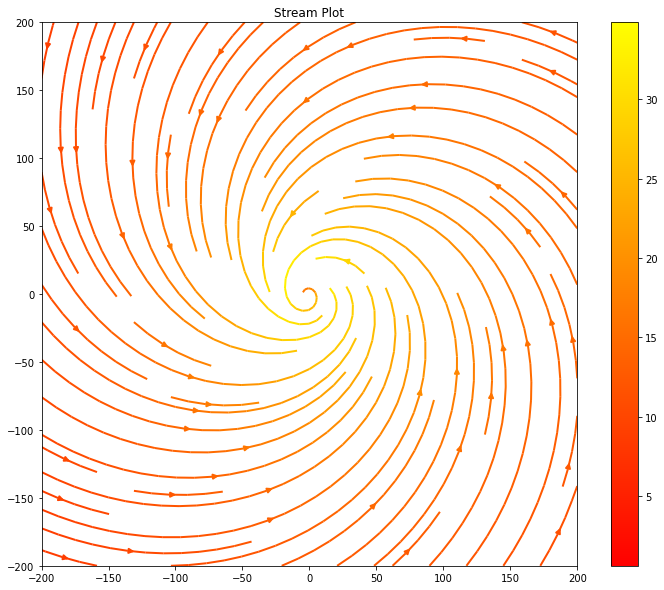

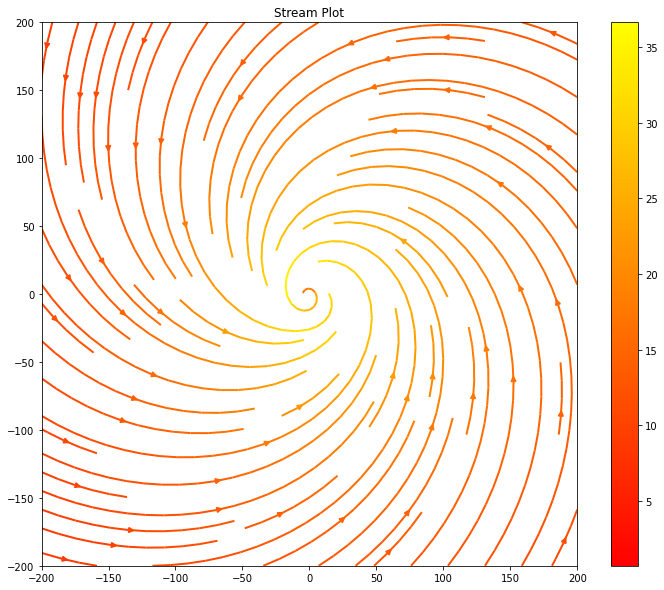

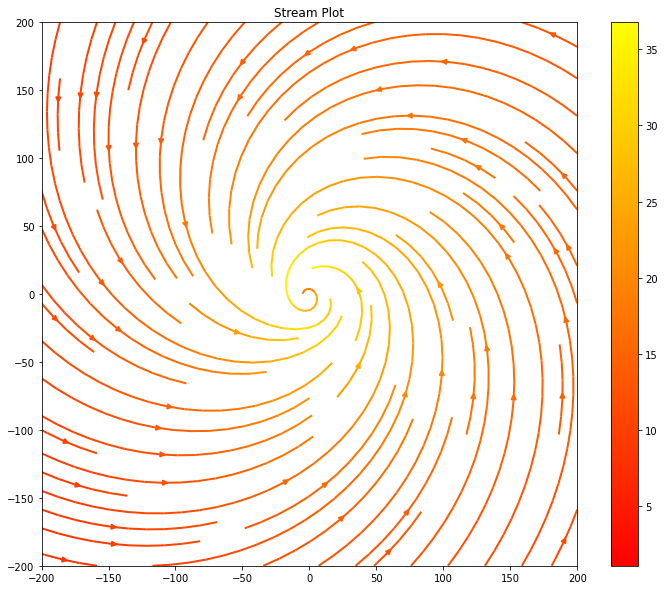

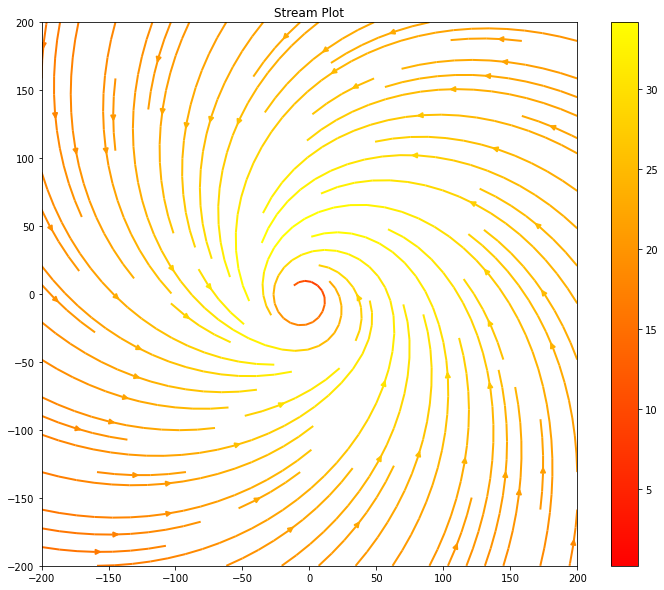

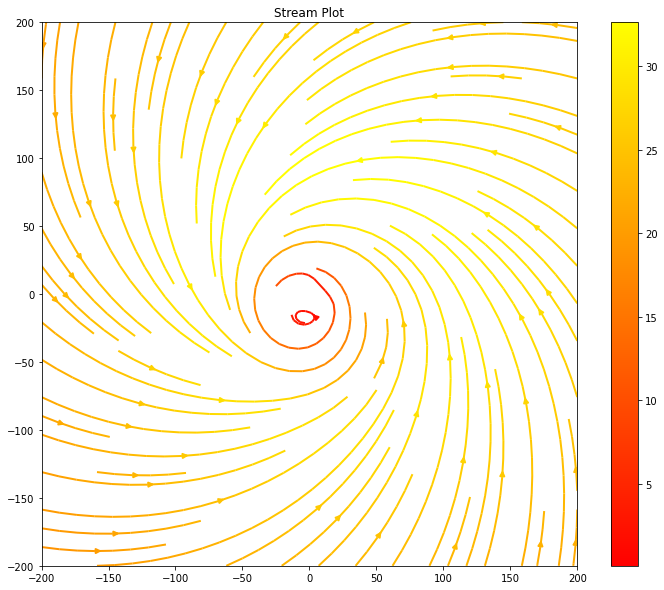

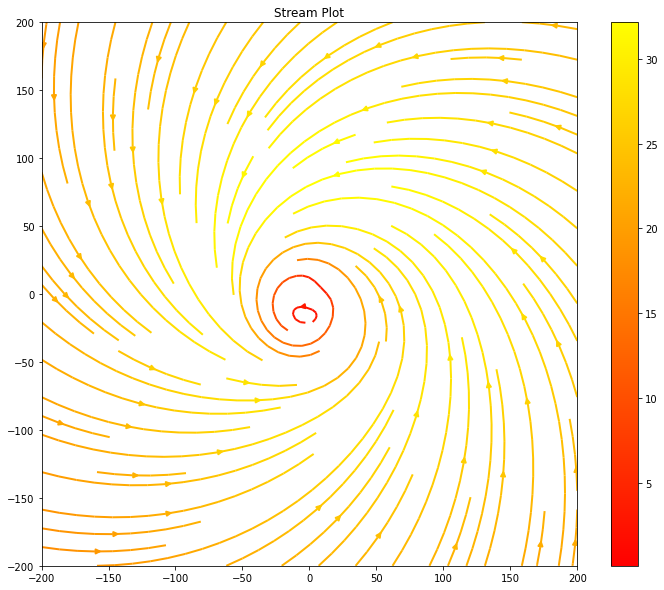

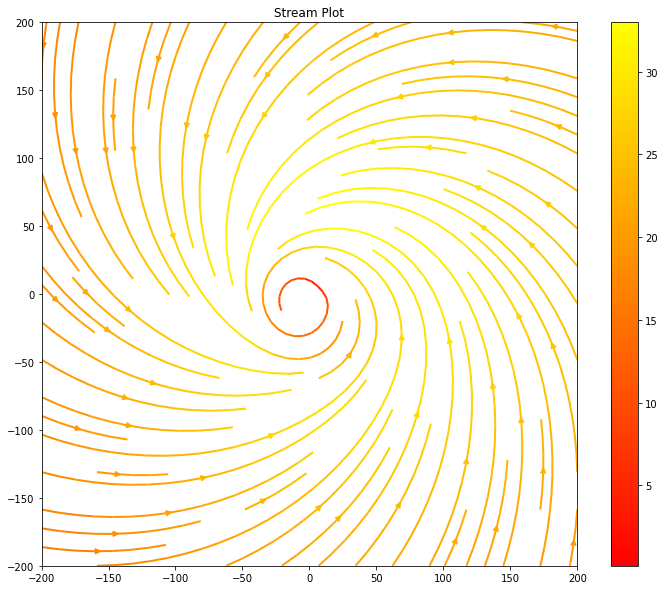

KeyboardInterrupt: 

In [5]:
#input
snapshottimes = 12

k = 0.35

del_t = 60

#PBL Height 
h = 650

alpha = 0.5

beta = 0.5

B_1 = 1
B_2 = 1

angle = np.pi/12
pindex = 12
Rindex = 12

#mean air density
rho = 1.15

#NetCDF data
fn ='./ikecdf12ws.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

num_lat = 48*2
num_lon = 58*2

r_ramp = 100000

time = ds.createDimension('time', None)
lat = ds.createDimension('lat', num_lat)
lon = ds.createDimension('lon', num_lon)
loc = ds.createDimension('loc', 2)

times = ds.createVariable('time', 'f4', ('time',))
lats = ds.createVariable('lat', 'f4', ('lat',))
lons = ds.createVariable('lon', 'f4', ('lon',))
u_net = ds.createVariable('u', 'f4', ('time', 'lat', 'lon',))
v_net = ds.createVariable('v', 'f4', ('time', 'lat', 'lon',))
pressure_net = ds.createVariable('pressure', 'f4', ('time','lat', 'lon',))
eye_loc_net = ds.createVariable('eye_loc', 'f4', ('time', 'loc',))


lats[:] = np.arange(8.0, 32.0, 0.25)
lons[:] = np.arange(-99.0, -70.0, 0.25)
times[:] = np.arange(0, 6*60*60*snapshottimes, 6*60*60)
XT, YT = np.meshgrid(lons, lats)

for i in range(snapshottimes):
    global v_g,u_g,u_c,v_c,f, del_p_1 ,del_p_2,del_p_3,del_p_4,datetime,dx, snapt,centerpressure, outpressure
    snapt = i
    dx = float(data[i][39])*1852/160
    datetime = data[i][6]
    datetime = datetime.replace("/", ".")
    stormspeed = float(data[i][-2])
    travelangle = float(data[i][-1])
    u_c = np.cos((90-travelangle)*np.pi/180)*stormspeed*0.514444
    v_c = np.sin((90-travelangle)*np.pi/180)*stormspeed*0.514444
    
    #effective geostrophic flow relative to the low center
    u_g = -u_c

    v_g = -v_c
    
    lat = float(data[i][8])*np.pi/180
    eye_loc_net[i,0] = float(data[i][9])
    eye_loc_net[i,1] = float(data[i][8])
    
    f = 2*7.29*10**(-5)*np.sin(lat)
    
    #total change in pressure by quadrant
    centerpressure = float(data[i][24])*100
    outpressure = float(data[i][38])*100
    del_p_1 = outpressure - centerpressure
    del_p_2 = outpressure - centerpressure
    del_p_3 = outpressure - centerpressure
    del_p_4 = outpressure - centerpressure

    #scales radius by quadrant
    global R_p_1_1,R_p_2_1,R_p_3_1, R_p_4_1,R_p_1_2,R_p_2_2,R_p_3_2,R_p_4_2 
    RMW = float(data[i][40])*1852
    R_p_1_1 = RMW
    R_p_2_1 = RMW
    R_p_3_1 = RMW
    R_p_4_1 = RMW

    R_p_1_2 = 40000
    R_p_2_2 = 40000
    R_p_3_2 = 40000
    R_p_4_2 = 40000

    #pressure double exponential first term
    global del_p_1_1,del_p_2_1, del_p_3_1 ,del_p_4_1,del_p_1_2 ,del_p_2_2,del_p_3_2,del_p_4_2
    del_p_1_1 = outpressure - centerpressure
    del_p_2_1 = outpressure - centerpressure
    del_p_3_1 = outpressure - centerpressure
    del_p_4_1 = outpressure - centerpressure

    del_p_1_2 = del_p_1 - del_p_1_1
    del_p_2_2 = del_p_2 - del_p_2_1
    del_p_3_2 = del_p_3 - del_p_3_1
    del_p_4_2 = del_p_4 - del_p_4_1

    start()
    
